# DISPLAY MAPS

## Display sea ice statistics maps in the Weddell Sea using .nc files
- Read netCDF files for the sea ice statistics
- Draw sea ice statistics maps in the Weddell Sea

Credited by Younghyun Koo (kooala317@gmail.com)

## (1) Import necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, glob
import numpy as np
import h5py

import matplotlib.pylab as plt
from math import *
import time
import pandas as pd
import datetime as dt
from tqdm import tqdm
import geopandas
import json
from datetime import datetime, timedelta
from scipy import stats
from scipy.ndimage import gaussian_filter1d

import xarray as xr
from netCDF4 import date2num,num2date
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pickle

from pyproj import Proj, transform

%load_ext autoreload
%autoreload 2
from functions_floes import *

%matplotlib inline

## Accuracy assessment

In [2]:
year = 2019
th_fb = 0.8
th_sigma = 0.02
th_std = 0.1
df_all = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_Weddell_2019_fb{th_fb}_sigma{th_sigma}_std{th_std}.csv", index_col = 0)
df_all = df_all[df_all['width'] > 1000].reset_index(drop = True)

bbox = [-62, -77.6, -15, -60]

In [22]:
df_all['fb_mean']

0      3.709296
1      1.559656
2      1.014866
3      1.271165
4      1.003370
         ...   
844    1.203439
845    2.196441
846    1.187844
847    1.326156
848    1.792266
Name: fb_mean, Length: 849, dtype: float64

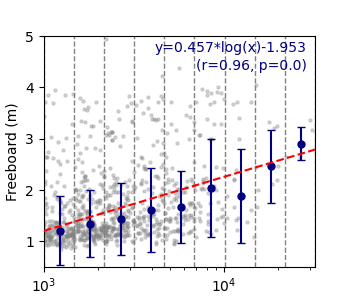

In [78]:
min_size = 1000
max_size = 32000
levels = np.logspace(np.log10(min_size), np.log10(max_size), num=10)
levels_mean = np.zeros(len(levels) - 1)

fsi_width = df_all['width'].values
fsi_fb = df_all['fb_mean'].values

fig, ax = plt.subplots(1,1,dpi = 100, figsize = (3.5, 3 ))
ax.scatter(fsi_width, fsi_fb, s = 5, color = "gray", alpha = 0.3)
for i, l in enumerate(levels):
    if i > 0:
        w = np.where((fsi_width >= levels[i-1]) & (fsi_width < levels[i]))
        mean = np.median(fsi_fb[w])
        # med = np.median(floe_fb_med[idx][w])
        std = np.std(fsi_fb[w])
        levels_mean[i-1] = np.mean(fsi_fb[w])
        # plt.errorbar(l, levels_mean[i-1])
        ax.errorbar((levels[i]+levels[i-1])/2, mean, yerr = std, fmt ='o', color = "navy", markersize = 5, capsize=3)
    ax.axvline(l, ls = "--", c = "gray", lw = 1)
    
res = stats.linregress(np.log(levels[1:]), levels_mean)
b = res.intercept
a = res.slope
ax.plot(levels, np.log(levels)*a + b, color = "red", ls = "--", lw = 1.5, zorder = 15)

ax.set_xscale('log')
ax.set_ylabel('Freeboard (m)')
ax.set_xlabel('Landfast ice floe length (m)')
    
ax.set_ylim(0.5, 5)
ax.set_xlim(min_size, max_size)

# ax.annotate(text, xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
# ax.annotate(f"(d)", xy=(0.02, 0.98), xycoords='axes fraction', fontsize=12, ha='left', va='top')
ax.annotate(f"y={round(a, 3)}*log(x){round(b,3)}", xy=(0.97, 0.98), xycoords='axes fraction',
            fontsize=10, ha='right', va='top', color = "navy")
ax.annotate(f"(r={round(res.rvalue, 3)}, p={round(res.pvalue, 3)})", xy=(0.97, 0.90), xycoords='axes fraction',
            fontsize=10, ha='right', va='top', color = "navy")
plt.savefig("D:\Documents\Submit_paper\Landfast_Weddell\Floelen_freeboard.png", bbox_inches = "tight")

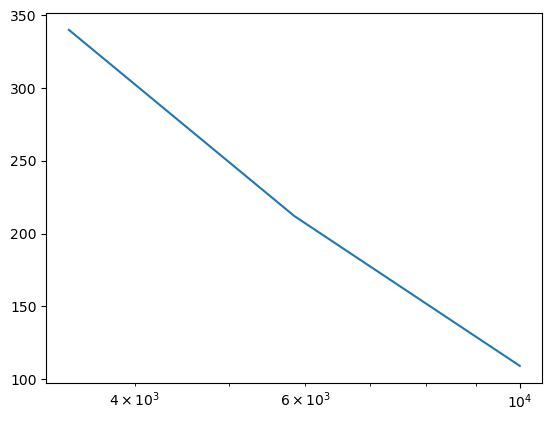

In [3]:
plt.figure()

data = df_all['width'].values
a, b = np.histogram(data, bins=np.logspace(np.log10(2000),np.log10(10000), 4))
# a,b = plt.hist(data, bins=np.logspace(np.log10(1000),np.log10(15000), 10))
plt.plot(b[1:],a)
plt.xscale('log')
# plt.close()

In [233]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
lengths = [2000, 3500, 6000, 10000, 1000000]

array = np.zeros((len(months), len(lengths)))

for i, m in enumerate(months):
    df_part = df_all[(df_all['month'] >= m-1) & (df_all['month'] <= m+1)]
    for j, L in enumerate(lengths[:-1]):
        array[i,j] = df_part.loc[(df_part['width'] >= lengths[j]) & (df_part['width'] < lengths[j+1]), "fb_mean"].mean()
    
    

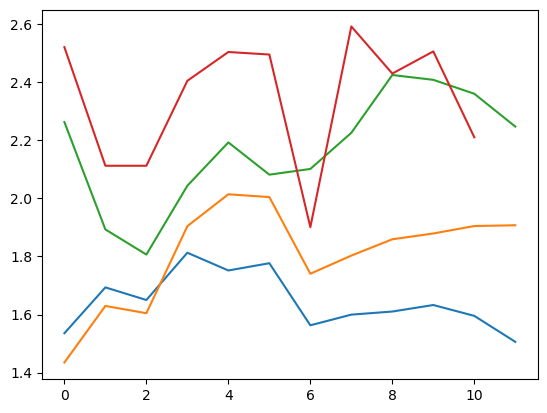

In [122]:
for j, L in enumerate(lengths[:-1]):
    plt.plot(array[:, j])

In [10]:
df_count = df_all.groupby(["filename", "beam"]).count()
df_med = df_all.groupby(["filename", "beam"]).median()
df_count = df_count[df_count['day'] > 1]
files = df_count.sort_values(by = "width", ascending = False).loc[:, ['lat']].index.unique().sort_values()

In [6]:
ds.close()

In [8]:
# Enter name of the .nc file
ncname = f'D:\\Floes\\array\\Grid_fb_v6_entire2019_w_ibfiltering_fb0.8.nc'
ds = xr.open_dataset(ncname)

with netCDF4.Dataset(ncname, 'r') as nc:
    x = np.array(nc.variables['x'])
    y = np.array(nc.variables['y'])
    xx, yy = np.meshgrid(x, y)
    lat = np.array(nc.variables['lat'])
    lon = np.array(nc.variables['lon'])
    
    times = np.array(nc.variables['time'])
    t = num2date(nc.variables['time'], nc.variables['time'].units)

In [11]:
df_anal = pd.DataFrame()
fb_pi = np.array(ds["fb_mode"])

k = 0

for n in tqdm(range(0, len(files[:]))):    
    
    filename = files[n][0]
    beam = files[n][1]

    date0 = datetime.strptime(filename[9:17], "%Y%m%d")
    date1 = date0 - timedelta(days = 2)
    date2 = date0 + timedelta(days = 2)
    idx = (t >= date1) & (t <= date2)
    grid = np.nanmean(fb_pi[idx], axis=0)

    df_raw = read_ATL10("D:\\Floes\\ATL10\\" + filename, bbox)
    df = df_raw.loc[df_raw['beam']==beam, :].reset_index(drop = True)
    # df['fb_mode'] = smooth_line(df['fb_mode'].values, df['seg_x'].values, 5000) #gaussian_filter1d(df['fb_mode'], 100)    

    df_part = df_all[(df_all['filename'] == filename) & (df_all['beam'] == beam)]    

    for p in df_part.index:
        
        lat_p = df_part.loc[p].lat.mean()
        lon_p = df_part.loc[p].lon.mean()

        df_anal.loc[k, "filename"] = filename
        df_anal.loc[k, "beam"] = beam
        df_anal.loc[k, "date"] = date0
        df_anal.loc[k, "year"] = date0.year
        df_anal.loc[k, "month"] = date0.month
        df_anal.loc[k, "day"] = date0.day
        df_anal.loc[k, "lat"] = df_part.loc[p].lat
        df_anal.loc[k, "lon"] = df_part.loc[p].lon
        
        fb_p = df.loc[df_part.loc[p].id_st:df_part.loc[p].id_en]['fb'].values
        df_anal.loc[k, "fb_mode_fsi"] = calculate_mode(fb_p, fb_max = 4.0)
        df_anal.loc[k, "fb_mean_fsi"] = df_part.loc[p].fb_mean
        df_anal.loc[k, "fb_max_fsi"] = df_part.loc[p].fb_max
        df_anal.loc[k, "fb_min_fsi"] = df_part.loc[p].fb_min
        df_anal.loc[k, "fb_std_fsi"] = df_part.loc[p].fb_min
        df_anal.loc[k, "width"] = df_part.loc[p].width

        d_min = np.min((lat - lat_p)**2 + (lon - lon_p)**2)
        a, b = np.where((lat - lat_p)**2 + (lon - lon_p)**2 == d_min)

        df_anal.loc[k, "fb_mode_pi"] = np.nanmean(grid[a[0]-1:a[0]+2, b[0]-1:b[0]+2])
        df_anal.loc[k, "fb_std_pi"] = np.nanstd(grid[a[0]-1:a[0]+2, b[0]-1:b[0]+2])

        k += 1
    

    # # th_fb2 = np.where(df['fb_mode']+0.6 > th_fb, df['fb_mode']+0.6, th_fb)
    # ib_mask2, df_ib = determine_iceberg(df, th_fb, th_sigma, th_std)
    # df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2, th_fb = 0.8)
    # df['ib_mask'] = ib_mask3.astype(int)

    # if ib_filtering:
    #     df = df[ib_mask3 == 0].reset_index(drop = True)
    # ######################################################
    # lat = df['lat'].values
    # lon = df['lon'].values
    # seg_x = df['seg_x'].values
    # seg_len = df['seg_len'].values
    # fb = df['fb'].values
    # stype = df['stype'].values
    # refsur_ndx = df['refsur_ndx'].values

    # freeboard_mode, sample_ndx = modal_profile(fb, seg_x, refsur_ndx)

    


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [05:53<00:00,  2.45s/it]


In [347]:
df_anal.sort_values(by = "width", ascending = False).head(10)

,filename,beam,date,year,month,day,lat,lon,fb_mode_fsi,fb_mean_fsi,fb_max_fsi,fb_min_fsi,fb_std_fsi,width,fb_mode_pi,fb_std_pi
194,ATL10-02_20190530185156_09550301_006_02.h5,gt1l,2019-05-30,2019.0,5.0,30.0,-72.364101,-55.683874,2.83,3.163248,4.558601,1.807030,1.807030,30665.354,0.223405,0.012874
185,ATL10-02_20190522190837_08330301_006_02.h5,gt3l,2019-05-22,2019.0,5.0,22.0,-74.066975,-55.168801,3.13,3.361194,5.090420,2.432598,2.432598,29833.906,0.244899,0.051924
167,ATL10-02_20190522190837_08330301_006_02.h5,gt1l,2019-05-22,2019.0,5.0,22.0,-73.953057,-54.887053,2.61,2.637459,3.714548,1.779224,1.779224,26529.127,0.244899,0.051924
401,ATL10-02_20191005125113_01320501_006_02.h5,gt3r,2019-10-05,2019.0,10.0,5.0,-67.559473,-55.393986,2.85,2.630341,3.588155,0.819313,0.819313,22439.810,0.433157,0.056514
119,ATL10-02_20190314215603_11680201_006_02.h5,gt1l,2019-03-14,2019.0,3.0,14.0,-75.501019,-48.184874,2.63,2.469461,3.706066,1.658276,1.658276,20009.338,0.198873,0.051725
195,ATL10-02_20190530185156_09550301_006_02.h5,gt1l,2019-05-30,2019.0,5.0,30.0,-72.813337,-55.886886,3.59,3.242892,4.278735,1.279138,1.279138,19711.310,0.228650,0.006244
427,ATL10-02_20191019003453_03380501_006_02.h5,gt1r,2019-10-19,2019.0,10.0,19.0,-68.234197,-54.063781,2.11,2.189870,3.255102,1.236308,1.236308,19553.440,0.457554,0.119469
380,ATL10-02_20190928014211_00180501_006_02.h5,gt2r,2019-09-28,2019.0,9.0,28.0,-68.210911,-55.806845,3.19,3.215514,3.928328,2.052035,2.052035,18920.795,0.474716,0.090491
20,ATL10-02_20190205233644_06040201_006_02.h5,gt3l,2019-02-05,2019.0,2.0,5.0,-77.249698,-48.386201,1.91,1.997486,2.791124,1.596492,1.596492,15403.039,0.395366,0.083737
449,ATL10-02_20191023002635_03990501_006_02.h5,gt1r,2019-10-23,2019.0,10.0,23.0,-68.077153,-54.892075,2.21,2.177593,2.634048,1.632875,1.632875,15265.625,0.327236,0.057862


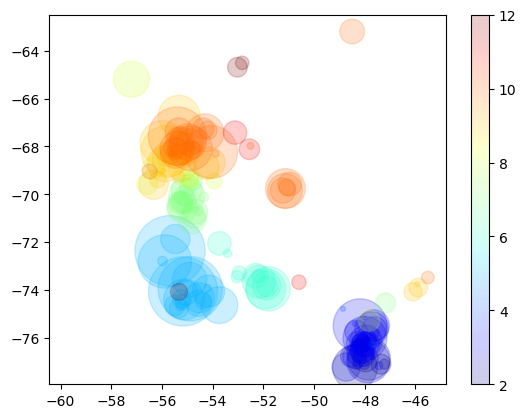

In [9]:
plt.scatter(df_anal.lon, df_anal.lat, s = (df_anal['width']-5000)*0.1, c = df_anal['month'], alpha = 0.2, cmap = "jet")
plt.colorbar()

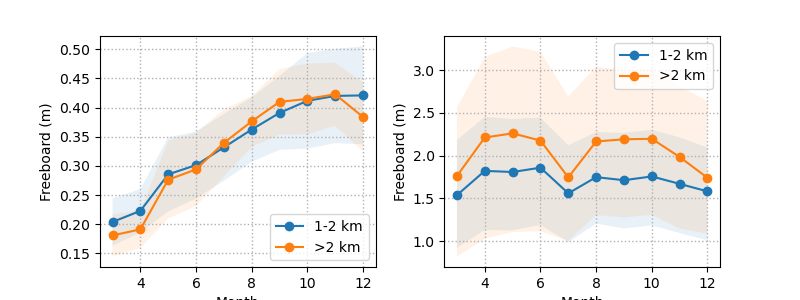

In [13]:
%matplotlib widget
months = [3,4,5,6,7,8,9,10,11,12]
lengths = [2000, 4000, 1000000]
labels = ["1-2 km", ">2 km", ">3 km"]

fig, ax = plt.subplots(1,2, figsize = (8,3), dpi = 100)
plt.subplots_adjust(hspace=0.05, wspace=0.25)

test = []

for j, L in enumerate(lengths[:-1]):
    array_fsi = np.zeros(len(months))
    std_fsi = np.zeros(len(months))
    max_fsi = np.zeros(len(months))
    min_fsi = np.zeros(len(months))
    array_pi = np.zeros(len(months))
    std_pi = np.zeros(len(months))

    lat_fsi = np.zeros(len(months))
    lon_fsi = np.zeros(len(months))
    dist = np.zeros(len(months))
    
    for i, m in enumerate(months):
        if m > 0:
            df_a2 = df_anal.loc[(df_anal['width'] >= lengths[j]) & (df_anal['width'] < lengths[j+1]) & (df_anal['month'] >= m-1) & ((df_anal['month'] <= m+1))]
        else:
            df_a2 = df_anal.loc[(df_anal['width'] >= lengths[j]) & (df_anal['width'] < lengths[j+1]) & (df_anal['month'] >= m) & ((df_anal['month'] <= m))]
        array_fsi[i] = np.sum(df_a2['fb_mean_fsi']*df_a2['width']) / df_a2['width'].sum() # df_a2['fb_mode_fsi'].mean()
        std_fsi[i] = np.sum(df_a2['fb_std_fsi']*df_a2['width']) / df_a2['width'].sum() # df_a2['fb_std_fsi'].median()
        max_fsi[i] = np.sum(df_a2['fb_max_fsi']*df_a2['width']) / df_a2['width'].sum() #df_a2['fb_max_fsi'].median()
        min_fsi[i] = np.sum(df_a2['fb_min_fsi']*df_a2['width']) / df_a2['width'].sum() #df_a2['fb_min_fsi'].median()
        array_pi[i] = df_a2['fb_mode_pi'].mean()
        std_pi[i] = df_a2['fb_std_pi'].median()

        lat_fsi[i] = np.sum(df_a2['lat']*df_a2['width']) / df_a2['width'].sum() #.median()
        lon_fsi[i] = np.sum(df_a2['lon']*df_a2['width']) / df_a2['width'].sum() #.median()
        dist[i] = np.sum(((df_a2['lat']-lat_fsi[i])**2 + (df_a2['lon']-lon_fsi[i])**2)**0.5)

        # ax[2].text(lon_fsi[i], lat_fsi[i], m)
        
    ax[0].plot(months, array_pi, 'o-', label = labels[j])
    ax[0].fill_between(months, array_pi - std_pi, array_pi + std_pi, alpha = 0.1)
    ax[1].plot(months, array_fsi, 'o-', label = labels[j])
    # ax[1].fill_between(months, array_fsi - std_fsi, array_fsi + std_fsi, alpha = 0.1)
    ax[1].fill_between(months, min_fsi, max_fsi, alpha = 0.1)

    test.append(array_fsi)

    # ax[0].set_title("(a) Modal freeboard of pack ice", fontsize = 12)
    # ax[1].set_title("(b) Modal freeboard of landfast ice", fontsize = 12)

    # ax[2].plot(lon_fsi, lat_fsi, '.-')
    # ax[2].scatter(lon_fsi, lat_fsi, s = dist, alpha = 0.5)

ax[0].legend(loc = "lower right")
ax[1].legend()

# ax[0].annotate('(a)',xy=(0.02, 0.98), xycoords='axes fraction', rotation = 0, size = 12, va = 'top', ha ='left')
# ax[1].annotate('(b)',xy=(0.02, 0.98), xycoords='axes fraction', rotation = 0, size = 12, va = 'top', ha ='left')

ax[0].grid(ls = ":", lw = 1)
ax[1].grid(ls = ":", lw = 1)

ax[0].set_xlabel("Month")
ax[1].set_xlabel("Month")

ax[0].set_ylabel("Freeboard (m)")
ax[1].set_ylabel("Freeboard (m)")

plt.show()
plt.savefig("D:\Documents\Submit_paper\Landfast_Weddell\Temporal_change.png", bbox_inches = "tight")

In [15]:
test[1] - test[0]

array([0.22504734, 0.39055477, 0.45281362, 0.31689731, 0.18675471,
       0.41760081, 0.47896472, 0.44067367, 0.31465165, 0.15858069])

In [84]:
yy.min(), yy.max()

(500000.0, 2975000.0)

10it [00:00, 19.37it/s]
10it [00:00, 23.08it/s]


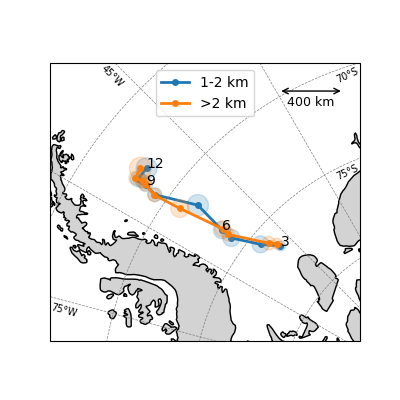

In [34]:
months = [3,4,5,6,7,8,9,10,11,12]
lengths = [2000, 4000, 1000000]
labels = ["1-2 km", ">2 km", ">3 km"]

projection = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude = -70)
fig, ax = plt.subplots(1,1, figsize = (4,4), dpi = 100, subplot_kw={'projection': projection})

traject = []

for j, L in enumerate(lengths[:-1]):

    x_fsi = np.zeros(len(months))
    y_fsi = np.zeros(len(months))
    dist = np.zeros(len(months))
    
    for i, m in tqdm(enumerate(months)):
        if m > 0:
            df_a2 = df_anal.loc[(df_anal['width'] >= lengths[j]) & (df_anal['width'] < lengths[j+1]) & (df_anal['month'] >= m-1) & ((df_anal['month'] <= m+1))]
        else:
            df_a2 = df_anal.loc[(df_anal['width'] >= lengths[j]) & (df_anal['width'] < lengths[j+1]) & (df_anal['month'] >= m) & ((df_anal['month'] <= m))]

        xp, yp = transform(Proj("EPSG:4326"), Proj("EPSG:3412"), df_a2['lat'].values, df_a2['lon'].values)
        x_fsi[i] = np.median(xp) # np.sum(df_a2['lat']*df_a2['width']) / df_a2['width'].sum() #df_a2['lat'].median()
        y_fsi[i] = np.median(yp) # np.sum(df_a2['lon']*df_a2['width']) / df_a2['width'].sum() #df_a2['lon'].median()
        dist[i] = np.median(((xp-x_fsi[i])**2 + (yp-y_fsi[i])**2)**0.5)
        if j == 0 and i % 3 == 0:
            ax.text(x_fsi[i], y_fsi[i], m)
    ax.scatter(x_fsi, y_fsi, s = dist/1000, alpha = 0.2, zorder = 2)
    # ax.pcolormesh(xx, yy, xx, vmax = 5, vmin = 0, cmap = "Blues", zorder = 0, alpha = 0)
    ax.plot(x_fsi, y_fsi, 'o-', zorder = 2, lw = 2, markersize = 4, label = labels[j])

    traject.append(((x_fsi[1:] - x_fsi[:-1])**2 + (y_fsi[1:] - y_fsi[:-1])**2)**0.5)

ax.legend(loc = "upper center")
ax.coastlines(zorder = 2)
ax.add_feature(cfeature.LAND, color = "lightgray", zorder = 1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs = np.arange(-180, 180, 15), ylocs = np.arange(-90, 90, 5),
                  linewidth=0.5, color='grey', linestyle='--', zorder = 3)

ax.annotate('45°W', xy=(0.16, 1.0), xycoords='axes fraction', rotation = -45, size = 7, va = 'top', ha ='left')
ax.annotate('75°W',xy=(0.0, 0.14), xycoords='axes fraction', rotation = -15, size = 7, va = 'top', ha ='left')

# ax.annotate('(c)',xy=(0.02, 0.98), xycoords='axes fraction', rotation = 0, size = 12, va = 'top', ha ='left')

xmin, xmax = ax.set_xlim(-2500000, -600000)
ymin, ymax = ax.set_ylim(400000, 2100000)

ax.annotate('', xy=(xmax-100000,ymax-170000), xytext=(xmax-500000, ymax-170000), arrowprops=dict(arrowstyle='<->'))
ax.annotate('400 km', xy=(xmax-100000,ymax-200000), xytext=(xmax-450000, ymax-200000), va = "top", fontsize = 9)

# ax[i].annotate('65°S', xy=(1.0, 0.95), xycoords='axes fraction', rotation = 10, size = 6, va = 'top', ha ='right')
ax.annotate('70°S',xy=(1.0, 0.99), xycoords='axes fraction', rotation = 25, size = 7, va = 'top', ha ='right')
# ax[i].annotate('75°S', xy=(1.0, 0.5), xycoords='axes fraction', rotation = 10, size = 6, va = 'top', ha ='right')
ax.annotate('75°S', xy=(1.0, 0.64), xycoords='axes fraction', rotation = 25, size = 7, va = 'top', ha ='right')
plt.savefig("D:\Documents\Submit_paper\Landfast_Weddell\Temporal_track.png", bbox_inches = "tight")

In [30]:
dist = ((x_fsi[1:] - x_fsi[:-1])**2 + (y_fsi[1:] - y_fsi[:-1])**2)**0.5

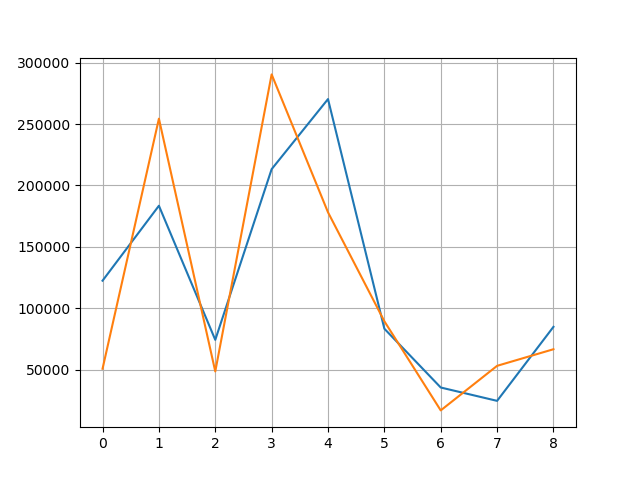

In [39]:
plt.figure()
plt.plot(traject[0])
plt.plot(traject[1])
plt.grid()

### Number of floes

5it [00:17,  3.59s/it]
5it [00:12,  2.49s/it]


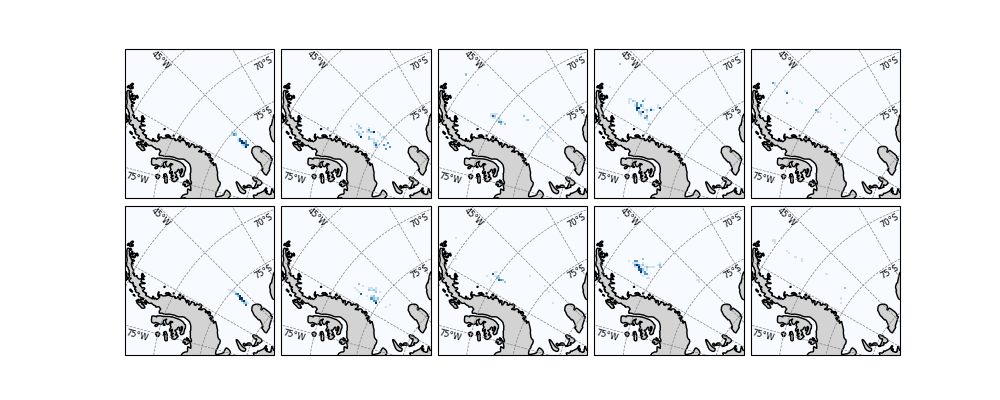

In [119]:
# Make grid for Weddell Sea (projection: NSIDC sea ice polar stereographic South - EPSG 3412)
wide = 1800000
y0 = 320000
x0 = -2500000
w = 25000
xp = np.arange(x0, x0+wide, w)
yp = np.arange(y0, y0+wide, w)

xx, yy = np.meshgrid(xp, yp)
lats, lons = transform(Proj("EPSG:3412"), Proj("EPSG:4326"), xx, yy)
## -------------------------------------------------------------------------

months = [3, 5, 7, 9, 11]
lengths = [2000, 4000, 1000000]
labels = ["1-2 km", ">2 km", ">3 km"]

projection = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude = -70)

fig, ax = plt.subplots(2, len(months), figsize = (2*len(months), 4), dpi = 100, subplot_kw={'projection': projection})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

colors = ["Blues", "Reds"]

for j, L in enumerate(lengths[:-1]):
    fsi_count = np.zeros((len(months), xx.shape[0], xx.shape[1]))
    fsi_fb = np.zeros((len(months), xx.shape[0], xx.shape[1]))
    fsi_width = np.zeros((len(months), xx.shape[0], xx.shape[1]))

    x_fsi = np.zeros(len(months))
    y_fsi = np.zeros(len(months))
    dist = np.zeros(len(months))
    
    for i, m in tqdm(enumerate(months)):
        if m > 0:
            df_a2 = df_anal.loc[(df_anal['width'] >= lengths[j]) & (df_anal['width'] < lengths[j+1]) & (df_anal['month'] >= m) & ((df_anal['month'] <= m+1))]
        else:
            df_a2 = df_anal.loc[(df_anal['width'] >= lengths[j]) & (df_anal['width'] < lengths[j+1]) & (df_anal['month'] >= m) & ((df_anal['month'] <= m))]

        for k in df_a2.index:
            
            xk, yk = transform(Proj("EPSG:4326"), Proj("EPSG:3412"), df_a2.loc[k, 'lat'], df_a2.loc[k, 'lon'])

            d_min = np.min((xx - xk)**2 + (yy - yk)**2)
            a, b = np.where((xx - xk)**2 + (yy - yk)**2 == d_min)

            fsi_count[i, a[0], b[0]] += 1
            fsi_fb[i, a[0], b[0]] += df_a2.loc[k, 'fb_mode_fsi']
            fsi_width[i, a[0], b[0]] += df_a2.loc[k, 'width']

        fsi_fb[i] = fsi_fb[i] / np.where(fsi_count[i] > 1, fsi_count[i], 1)
        fsi_width[i] = fsi_width[i] / np.where(fsi_count[i] > 1, fsi_count[i], 1)

        xp, yp = transform(Proj("EPSG:4326"), Proj("EPSG:3412"), df_a2['lat'].values, df_a2['lon'].values)
        x_fsi[i] = np.median(xp) # np.sum(df_a2['lat']*df_a2['width']) / df_a2['width'].sum() #df_a2['lat'].median()
        y_fsi[i] = np.median(yp) # np.sum(df_a2['lon']*df_a2['width']) / df_a2['width'].sum() #df_a2['lon'].median()
        dist[i] = np.median(((xp-x_fsi[i])**2 + (yp-y_fsi[i])**2)**0.5)

        ax[j,i].pcolormesh(xx, yy, fsi_count[i], vmax = 5, vmin = 0, cmap = colors[0], zorder = 0)

        ax[j,i].coastlines(zorder = 2)
        ax[j,i].add_feature(cfeature.LAND, color = "lightgray", zorder = 1)

        gl = ax[j,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs = np.arange(-180, 180, 15), ylocs = np.arange(-90, 90, 5),
                              linewidth=0.5, color='grey', linestyle='--', zorder = 3)

        ax[j,i].annotate('45°W', xy=(0.16, 1.0), xycoords='axes fraction', rotation = -45, size = 6, va = 'top', ha ='left')
        ax[j,i].annotate('75°W',xy=(0.0, 0.18), xycoords='axes fraction', rotation = -15, size = 6, va = 'top', ha ='left')
        
        # ax[i].annotate('65°S', xy=(1.0, 0.95), xycoords='axes fraction', rotation = 10, size = 6, va = 'top', ha ='right')
        ax[j,i].annotate('70°S',xy=(1.0, 0.96), xycoords='axes fraction', rotation = 30, size = 6, va = 'top', ha ='right')
        # ax[i].annotate('75°S', xy=(1.0, 0.5), xycoords='axes fraction', rotation = 10, size = 6, va = 'top', ha ='right')
        ax[j,i].annotate('75°S', xy=(1.0, 0.62), xycoords='axes fraction', rotation = 30, size = 6, va = 'top', ha ='right')
    #     ax[j,i].scatter(x_fsi[i], y_fsi[i], s = dist[i]/1000, facecolors='none', edgecolors='b', alpha = 0.5, zorder = 1)

    # for i, m in enumerate(months):
    #     ax[j,i].plot(x_fsi, y_fsi, zorder = 2, c = "k", lw = 0.5, markersize = 4)
    #     ax[j,i].scatter(x_fsi[i], y_fsi[i], zorder = 2, s = 5, c = "b")

plt.savefig("D:\Documents\Submit_paper\Landfast_Weddell\Map_landfast_count.png", bbox_inches = "tight")

In [67]:
dist

array([ 42728.50049911,  74552.97933631,  71590.48254031,  67107.45663789,
       385669.42215884])

5it [00:15,  3.18s/it]
5it [00:11,  2.35s/it]


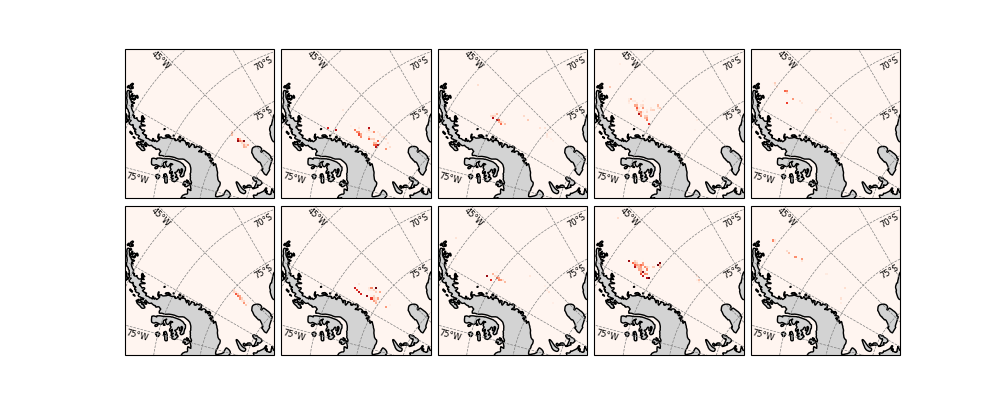

In [120]:
# Make grid for Weddell Sea (projection: NSIDC sea ice polar stereographic South - EPSG 3412)
wide = 1800000
y0 = 320000
x0 = -2500000
w = 25000
xp = np.arange(x0, x0+wide, w)
yp = np.arange(y0, y0+wide, w)

xx, yy = np.meshgrid(xp, yp)
lats, lons = transform(Proj("EPSG:3412"), Proj("EPSG:4326"), xx, yy)
## -------------------------------------------------------------------------

months = [3, 5, 7, 9, 11]
lengths = [2000, 4000, 1000000]
labels = ["1-2 km", ">2 km", ">3 km"]

projection = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude = -70)

fig, ax = plt.subplots(2, len(months), figsize = (2*len(months), 4), dpi = 100, subplot_kw={'projection': projection})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

colors = ["Blues", "Reds"]

for j, L in enumerate(lengths[:-1]):
    fsi_count = np.zeros((len(months), xx.shape[0], xx.shape[1]))
    fsi_fb = np.zeros((len(months), xx.shape[0], xx.shape[1]))
    fsi_width = np.zeros((len(months), xx.shape[0], xx.shape[1]))
    
    for i, m in tqdm(enumerate(months)):
        if m > 0:
            df_a2 = df_anal.loc[(df_anal['width'] >= lengths[j]) & (df_anal['width'] < lengths[j+1]) & (df_anal['month'] >= m) & ((df_anal['month'] <= m+1))]
        else:
            df_a2 = df_anal.loc[(df_anal['width'] >= lengths[j]) & (df_anal['width'] < lengths[j+1]) & (df_anal['month'] >= m) & ((df_anal['month'] <= m))]

        for k in df_a2.index:
            
            xk, yk = transform(Proj("EPSG:4326"), Proj("EPSG:3412"), df_a2.loc[k, 'lat'], df_a2.loc[k, 'lon'])

            d_min = np.min((xx - xk)**2 + (yy - yk)**2)
            a, b = np.where((xx - xk)**2 + (yy - yk)**2 == d_min)

            fsi_count[i, a[0], b[0]] += 1
            fsi_fb[i, a[0], b[0]] += df_a2.loc[k, 'fb_mode_fsi']
            fsi_width[i, a[0], b[0]] += df_a2.loc[k, 'width']

        fsi_fb[i] = fsi_fb[i] / np.where(fsi_count[i] > 1, fsi_count[i], 1)
        fsi_width[i] = fsi_width[i] / np.where(fsi_count[i] > 1, fsi_count[i], 1)

        ax[j,i].pcolormesh(xx, yy, fsi_fb[i], vmax = 4, vmin = 1, cmap = "Reds", zorder = 0)

        ax[j,i].coastlines(zorder = 2)
        ax[j,i].add_feature(cfeature.LAND, color = "lightgray", zorder = 1)

        gl = ax[j,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs = np.arange(-180, 180, 15), ylocs = np.arange(-90, 90, 5),
                              linewidth=0.5, color='grey', linestyle='--', zorder = 3)

        ax[j,i].annotate('45°W', xy=(0.16, 1.0), xycoords='axes fraction', rotation = -45, size = 6, va = 'top', ha ='left')
        ax[j,i].annotate('75°W',xy=(0.0, 0.18), xycoords='axes fraction', rotation = -15, size = 6, va = 'top', ha ='left')
        
        # ax[i].annotate('65°S', xy=(1.0, 0.95), xycoords='axes fraction', rotation = 10, size = 6, va = 'top', ha ='right')
        ax[j,i].annotate('70°S',xy=(1.0, 0.96), xycoords='axes fraction', rotation = 30, size = 6, va = 'top', ha ='right')
        # ax[i].annotate('75°S', xy=(1.0, 0.5), xycoords='axes fraction', rotation = 10, size = 6, va = 'top', ha ='right')
        ax[j,i].annotate('75°S', xy=(1.0, 0.62), xycoords='axes fraction', rotation = 30, size = 6, va = 'top', ha ='right')

plt.savefig("D:\Documents\Submit_paper\Landfast_Weddell\Map_landfast_freeboard.png", bbox_inches = "tight")

5it [00:00, 70.74it/s]
5it [00:00, 75.41it/s]


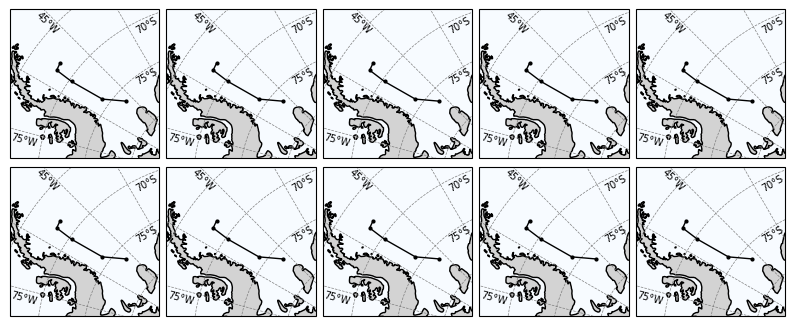

In [77]:
# Make grid for Weddell Sea (projection: NSIDC sea ice polar stereographic South - EPSG 3412)
wide = 1800000
y0 = 320000
x0 = -2500000
w = 25000
xp = np.arange(x0, x0+wide, w)
yp = np.arange(y0, y0+wide, w)

projection = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude = -70)

xx, yy = np.meshgrid(xp, yp)
lats, lons = transform(projection, Proj("EPSG:4326"), xx, yy)
## -------------------------------------------------------------------------

months = [3, 5, 7, 9, 11]
lengths = [2000, 4000, 1000000]
labels = ["1-2 km", ">2 km", ">3 km"]



fig, ax = plt.subplots(2, len(months), figsize = (2*len(months), 4), dpi = 100, subplot_kw={'projection': projection})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

for j, L in enumerate(lengths[:-1]):
    fsi_count = np.zeros((len(months), xx.shape[0], xx.shape[1]))
    fsi_fb = np.zeros((len(months), xx.shape[0], xx.shape[1]))
    fsi_width = np.zeros((len(months), xx.shape[0], xx.shape[1]))
    
    for i, m in tqdm(enumerate(months)):
        
        ax[j,i].pcolormesh(xx, yy, fsi_count[i], vmax = 5, vmin = 0, cmap = "Blues", zorder = 0)

        ax[j,i].coastlines(zorder = 2)
        ax[j,i].add_feature(cfeature.LAND, color = "lightgray", zorder = 1)

        gl = ax[j,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs = np.arange(-180, 180, 15), ylocs = np.arange(-90, 90, 5),
                              linewidth=0.5, color='grey', linestyle='--', zorder = 3)

        ax[j,i].annotate('45°W', xy=(0.16, 1.0), xycoords='axes fraction', rotation = -45, size = 7, va = 'top', ha ='left')
        ax[j,i].annotate('75°W',xy=(0.0, 0.18), xycoords='axes fraction', rotation = -15, size = 7, va = 'top', ha ='left')
        
        # ax[i].annotate('65°S', xy=(1.0, 0.95), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[j,i].annotate('70°S',xy=(1.0, 0.96), xycoords='axes fraction', rotation = 30, size = 7, va = 'top', ha ='right')
        # ax[i].annotate('75°S', xy=(1.0, 0.5), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[j,i].annotate('75°S', xy=(1.0, 0.62), xycoords='axes fraction', rotation = 30, size = 7, va = 'top', ha ='right')

    for i, m in enumerate(months):
        ax[j,i].plot(x_fsi, y_fsi, 'o-', zorder = 2, c = "k", lw = 1, markersize = 2)

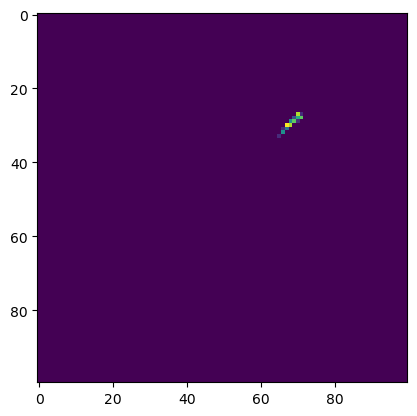

In [25]:
months = [3,4,5,6,7,8,9,10,11,12]
lengths = [2000, 4000, 1000000]
labels = ["1-2 km", ">2 km", ">3 km"]

fig, ax = plt.subplots(2, len(months), figsize = (12, 1.5), dpi = 100)

for j, L in enumerate(lengths[:-1]):
    fsi_count = np.zeros((len(months), xx.shape[0], xx.shape[1]))
    fsi_fb = np.zeros((len(months), xx.shape[0], xx.shape[1]))
    fsi_width = np.zeros((len(months), xx.shape[0], xx.shape[1]))
    
    for i, m in tqdm(enumerate(months)):
        if m > 0:
            df_a2 = df_anal.loc[(df_anal['width'] >= lengths[j]) & (df_anal['width'] < lengths[j+1]) & (df_anal['month'] >= m-1) & ((df_anal['month'] <= m+1))]
        else:
            df_a2 = df_anal.loc[(df_anal['width'] >= lengths[j]) & (df_anal['width'] < lengths[j+1]) & (df_anal['month'] >= m) & ((df_anal['month'] <= m))]

        for k in df_a2.index:
            
            xk, yk = transform(Proj("EPSG:4326"), Proj("EPSG:3412"), df_a2.loc[k, 'lat'], df_a2.loc[k, 'lon'])

            d_min = np.min((xx - xk)**2 + (yy - yk)**2)
            a, b = np.where((xx - xk)**2 + (yy - yk)**2 == d_min)

            fsi_count[i, a[0], b[0]] += 1
            fsi_fb[i, a[0], b[0]] += df_a2.loc[k, 'fb_mode_fsi']
            fsi_width[i, a[0], b[0]] += df_a2.loc[k, 'width']

        fsi_fb[i] = fsi_fb[i] / np.where(fsi_count[i] > 1, fsi_count[i], 1)
        fsi_width[i] = fsi_width[i] / np.where(fsi_count[i] > 1, fsi_count[i], 1)

        ax[j,i].pcolormesh(xx, yy, fsi_count[i], vmax = 10, vmin = 0)

In [114]:
th_fb = 1.0
th_sigma = 0.018
th_std = 0.08
ib_filtering = False

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation

    df_raw = read_ATL10(filename, bbox)
    df = df_raw.loc[df_raw['beam']==beam, :].reset_index(drop = True)
    # df['fb_mode'] = smooth_line(df['fb_mode'].values, df['seg_x'].values, 5000) #gaussian_filter1d(df['fb_mode'], 100)

    # th_fb2 = np.where(df['fb_mode']+0.6 > th_fb, df['fb_mode']+0.6, th_fb)
    ib_mask2, df_ib = determine_iceberg(df, th_fb, th_sigma, th_std)
    df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2, th_fb = 0.8)
    df['ib_mask'] = ib_mask3.astype(int)

    if ib_filtering:
        df = df[ib_mask3 == 0].reset_index(drop = True)
    ######################################################
    lat = df['lat'].values
    lon = df['lon'].values
    seg_x = df['seg_x'].values
    seg_len = df['seg_len'].values
    fb = df['fb'].values
    stype = df['stype'].values
    refsur_ndx = df['refsur_ndx'].values

    freeboard_mode, sample_ndx = modal_profile(fb, seg_x, refsur_ndx)

    ridge = np.zeros(np.shape(fb))
    # Ridge or not? (threshold 0.6 m above level (mode) freeboard)
    ridge[fb > freeboard_mode + 0.6] = 1

    df['fb_mode'] = freeboard_mode
    df['ridge'] = ridge

print(filename)

MultiIndex([('ATL10-02_20190201234503_05430201_006_02.h5', 'gt1l'),
            ('ATL10-02_20190205233644_06040201_006_02.h5', 'gt1l'),
            ('ATL10-02_20190205233644_06040201_006_02.h5', 'gt2l'),
            ('ATL10-02_20190205233644_06040201_006_02.h5', 'gt3l'),
            ('ATL10-02_20190302222103_09850201_006_02.h5', 'gt3l'),
            ('ATL10-02_20190310110421_11000201_006_02.h5', 'gt1l'),
            ('ATL10-02_20190310110421_11000201_006_02.h5', 'gt2l'),
            ('ATL10-02_20190310110421_11000201_006_02.h5', 'gt3l'),
            ('ATL10-02_20190310220423_11070201_006_02.h5', 'gt1l'),
            ('ATL10-02_20190310220423_11070201_006_02.h5', 'gt2l'),
            ('ATL10-02_20190310220423_11070201_006_02.h5', 'gt3l'),
            ('ATL10-02_20190314215603_11680201_006_02.h5', 'gt1l'),
            ('ATL10-02_20190314215603_11680201_006_02.h5', 'gt3l'),
            ('ATL10-02_20190318214743_12290201_006_02.h5', 'gt1l'),
            ('ATL10-02_20190404094841_00940301_0

## Draw profiles

In [341]:
n = 20
filename = "D:\\Floes\\ATL10\\" + "ATL10-02_20190522190837_08330301_006_02.h5" #files[n][0]
beam = "gt3l" #files[n][1]
# beam_nums = df_all.loc[df_all['filename'] == files[n], "beam_num"].unique()
print(filename, beam)

D:\Floes\ATL10\ATL10-02_20190522190837_08330301_006_02.h5 gt3l


In [342]:
th_fb = 1.0
th_sigma = 0.018
th_std = 0.08
ib_filtering = False

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation

    df_raw = read_ATL10(filename, bbox)
    df = df_raw.loc[df_raw['beam']==beam, :].reset_index(drop = True)
    # df['fb_mode'] = smooth_line(df['fb_mode'].values, df['seg_x'].values, 5000) #gaussian_filter1d(df['fb_mode'], 100)

    # th_fb2 = np.where(df['fb_mode']+0.6 > th_fb, df['fb_mode']+0.6, th_fb)
    ib_mask2, df_ib = determine_iceberg(df, th_fb, th_sigma, th_std)
    df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2, th_fb = 0.8)
    df['ib_mask'] = ib_mask3.astype(int)

    if ib_filtering:
        df = df[ib_mask3 == 0].reset_index(drop = True)
    ######################################################
    lat = df['lat'].values
    lon = df['lon'].values
    seg_x = df['seg_x'].values
    seg_len = df['seg_len'].values
    fb = df['fb'].values
    stype = df['stype'].values
    refsur_ndx = df['refsur_ndx'].values

    freeboard_mode, sample_ndx = modal_profile(fb, seg_x, refsur_ndx)

    ridge = np.zeros(np.shape(fb))
    # Ridge or not? (threshold 0.6 m above level (mode) freeboard)
    ridge[fb > freeboard_mode + 0.6] = 1

    df['fb_mode'] = freeboard_mode
    df['ridge'] = ridge

print(filename)

D:\Floes\ATL10\ATL10-02_20190522190837_08330301_006_02.h5


In [343]:
df.head(5)

,beam,lat,lon,seg_x,seg_len,fb,ph_rate,sigma,stype,refsur_ndx,sample_ndx,fb_std,fb_mode,ridge,ib_mask
0,gt3l,-62.000010,-51.073592,0.000000,12.755802,0.505737,7.526316,0.019484,1,13,130.0,NaN,0.185,0.0,0
1,gt3l,-62.000069,-51.073606,6.657534,12.762422,0.436401,7.842105,0.014966,1,13,130.0,0.045589,0.185,0.0,0
2,gt3l,-62.000123,-51.073618,12.731473,12.057351,0.419792,7.833333,0.011185,1,13,130.0,0.013775,0.185,0.0,0
3,gt3l,-62.000176,-51.073630,18.645206,12.774802,0.447132,7.210526,0.013964,1,13,130.0,0.041597,0.185,0.0,0
4,gt3l,-62.000238,-51.073644,25.552418,12.779069,0.501509,7.210526,0.015995,1,13,130.0,0.036067,0.185,0.0,0


D:\Floes\ATL10\ATL10-02_20190522190837_08330301_006_02.h5 14 5586


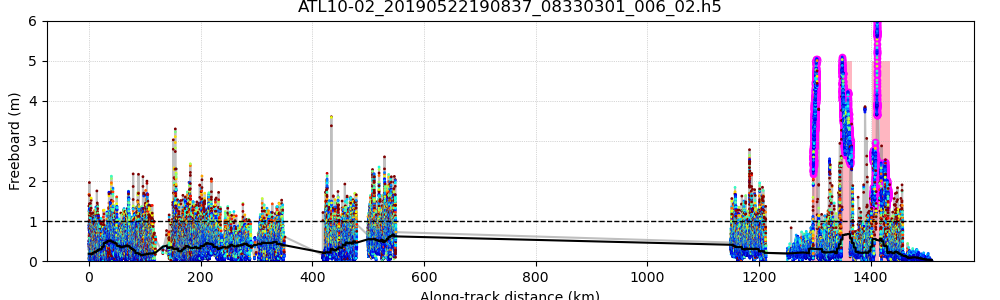

In [345]:
%matplotlib widget
print(filename, len(df_ib2), sum(ib_mask3))
fig, ax = plt.subplots(1,1, figsize = (10, 3))
fig.tight_layout()

# pm = ax.pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax.plot(df['seg_x']/1000, df['fb'], c="gray", zorder=1, alpha = 0.5)
ax.plot(df['seg_x']/1000, df['fb_mode'], c="k", zorder=10)
sc = ax.scatter(df['seg_x']/1000, df['fb'], c=df['fb_std'], s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby

# sc = ax.scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax.scatter(df['seg_x'][ib_mask3]/1000, df['fb'][ib_mask3], s= 20, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax.scatter(seg_x[ib_mask3]/1000 - seg_min, fb[ib_mask3]*0 + 4.2, s= 20, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax.scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(th_fb, ls = "--", lw = 1, c="k", zorder=2)
# ax.plot(df['seg_x']/1000, th_fb, c="k")
ax.vlines(df['seg_x'][ib_mask3]/1000, 0, 5, color="lightpink", zorder = 0, alpha = 0.5, lw = 1)

ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)

ax.set_ylabel("Freeboard (m)");

ax.set_ylim(0, 6);

ax.set_xlabel("Along-track distance (km)")

plt.show()
# plt.close()

## Figures for Floes paper

In [102]:
year = 2019
df_all = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_{region}_{year}_sigma{th_sigma}_std{th_std}.csv", index_col = 0)

bbox = [-65, -77.6, -15, -62]

In [103]:
df_all.head(5)

,filename,beam,beam_num,year,month,day,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
0,ATL10-02_20190106015150_01320201_006_02.h5,gt1l,2,2019,1,6,-74.696045,-58.104172,2.840756e+07,41937.0,41939.0,3.286645,4.139675,0.803014,1.655887,2962.105518
1,ATL10-02_20190128125318_04750201_006_02.h5,gt3l,2,2019,1,28,-77.048003,-45.411343,3.153924e+07,4889.0,4891.0,2.815334,3.749400,0.073831,1.827727,364.688665
2,ATL10-02_20190201124501_05360201_006_02.h5,gt1l,2,2019,2,1,-77.457868,-46.145792,3.149398e+07,2.0,218.0,2.208784,4.795080,1.040448,0.706147,1262.228372
3,ATL10-02_20190201124501_05360201_006_02.h5,gt3l,2,2019,2,1,-77.478857,-45.845838,3.149040e+07,103.0,169.0,1.534435,1.986665,1.192618,0.179018,357.599200
4,ATL10-02_20190201234503_05430201_006_02.h5,gt1l,2,2019,2,1,-76.910373,-47.072810,2.865782e+07,86533.0,86596.0,3.581594,3.901320,3.243701,0.100923,360.053550


In [105]:
df_count = df_all.groupby('filename').count()

In [131]:
files = df_count.sort_values(by = "lat", ascending = False).loc[:, ['beam']].head(12).index.unique().sort_values()

In [133]:
files

Index(['ATL10-02_20190310110421_11000201_006_02.h5',
       'ATL10-02_20190310220423_11070201_006_02.h5',
       'ATL10-02_20190518191658_07720301_006_02.h5',
       'ATL10-02_20190522190837_08330301_006_02.h5',
       'ATL10-02_20190530185156_09550301_006_02.h5',
       'ATL10-02_20190621061857_12830301_006_02.h5',
       'ATL10-02_20190731155540_05130401_006_02.h5',
       'ATL10-02_20190902142326_10160401_006_02.h5',
       'ATL10-02_20190906141506_10770401_006_02.h5',
       'ATL10-02_20191005125113_01320501_006_02.h5',
       'ATL10-02_20191019003453_03380501_006_02.h5',
       'ATL10-02_20191227084738_00100601_006_01.h5'],
      dtype='object', name='filename')

In [70]:
n = 8
filename = "D:\\Floes\\ATL10\\" + files[n]
beam_nums = df_all.loc[df_all['filename'] == files[n], "beam_num"].unique()
print(filename, beam_nums)

D:\Floes\ATL10\ATL10-02_20190127004437_04520201_006_02.h5 [0]


In [71]:
filename = "D:\\Floes\\ATL10\\" + files[n]
beam_num = 0

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    strong_beams = []

    if orient == 0:
        for i in [1, 2, 3]:
            if f"gt{i}l" in f.keys():
                strong_beams.append(f"gt{i}l")
    elif orient == 1:
        for i in [1, 2, 3]:
            if f"gt{i}r" in f.keys():
                strong_beams.append(f"gt{i}r")

    for beam in strong_beams[beam_num:beam_num+1]:

        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2]) & (fb <= 10)

        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]

        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
        sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]
        fb_std = pd.Series(fb).rolling(3, center = True).std().values

        df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len, 'fb': fb, 'ph_rate': ph_rate, 'sigma': sigma})

        ib_mask = (fb > 1.0) & (sigma < 0.03) & (fb_std < 0.1)
        ib_mask2, df_ib = determine_iceberg(df, ib_mask)
        df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2)

print(filename)

D:\Floes\ATL10\ATL10-02_20190127004437_04520201_006_02.h5


In [72]:
df_ib2

,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
0,-67.854187,-53.472409,2.763767e+07,56237.0,56342.0,1.552851,2.13494,1.013791,0.272408,652.142155


D:\Floes\ATL10\ATL10-02_20190127004437_04520201_006_02.h5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


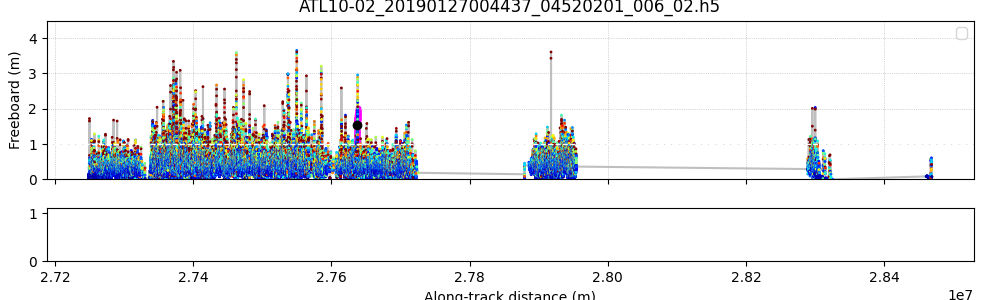

In [75]:
%matplotlib widget
print(filename)
fig, ax = plt.subplots(2,1, figsize = (10, 3), gridspec_kw={'height_ratios': [3, 1]}, sharex = True)
fig.tight_layout()

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.5)
sc = ax[0].scatter(seg_x, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax[0].scatter(seg_x[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

ax[0].errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
# fig.colorbar(sc)
ax[0].legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax[0].axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)

ax[0].set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32540*1000, 32620*1000);
# ax[0].set_xlim(32560*1000, 32580*1000);
# ax[0].set_xlim(32540*1000, 32560*1000);
# ax[0].set_xlim(32872.5*1000, 32882.5*1000);
# ax[0].set_xlim(32697.5*1000, 32705*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);

# ax[0].set_xlim(seg_x[int(df_ib2.loc[0, 'id_st'])]-1000, seg_x[int(df_ib2['id_st'].values[-1])]+1000);
ax[0].set_ylim(0, 4.5);

# a = np.sum(ratio[5:, ], axis = 0)
# ax[1].scatter(xx[0, :], a, c = a)
ax[1].set_ylim(0.0, 1.1)
ax[1].set_xlabel("Along-track distance (m)")

plt.show()
# plt.close()

## Figures for iceberg detection

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


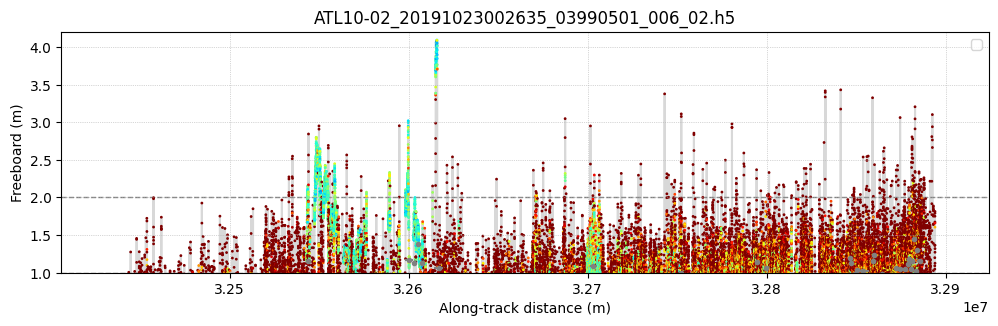

In [153]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(1,1, figsize = (10, 3))
fig.tight_layout()
ax.plot(seg_x, fb, c="gray", zorder=1, alpha = 0.3)
# ax.scatter(seg_x, fb, c=bck, s= 1, cmap = "jet", vmax = 500000) # background rate
# ax.scatter(seg_x, fb, c=asr, s= 1, cmap = "jet", vmax = 0.7, vmin = 0.6) # surface reflectance
ax.scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma
# ax.scatter(seg_x, fb, c=ph_rate, s= 1, cmap = "jet", vmax = 10, vmin = 5) # photon rate
# plt.scatter(floe_loc0, fb_mean0, s = 1, c = "k")
ax.errorbar(floe_loc0, fb_mean0, xerr = floe_len0/2, fmt ='.', color = "gray")
# ax.scatter(lead_pos0, lead_pos0*0, c= "k", s= 20, label = "leads")
ax.legend()
ax.axhline(1, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)
ax.axhline(2, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)

ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)
ax.set_xlabel("Along-track distance (m)")
ax.set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax.set_xlim(32540*1000, 32560*1000);
ax.set_ylim(1, 4.2);

plt.show()
# plt.close()

In [532]:
seg_x.max() - seg_x.min()

space = 1000
space_fb = 0.2

bin_seg_x = np.arange(np.floor(seg_x.min()/space)*space, np.floor(seg_x.max()/space)*space + space, space)
bin_fb = np.arange(0,5+space_fb, space_fb)

In [533]:
xx, yy = np.meshgrid(bin_seg_x + space/2, bin_fb + space_fb/2)
count = np.zeros(xx.shape)
ratio = np.zeros(xx.shape)
filter = np.zeros(xx.shape)

for i in range(0, xx.shape[0]-1):
    for j in range(0, xx.shape[1]-1):
        count[i, j] = np.sum((seg_x >= bin_seg_x[j]) & (seg_x < bin_seg_x[j+1]) & (fb >= bin_fb[i]) & (fb < bin_fb[i+1]))

ratio = count / np.sum(count, axis=0)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


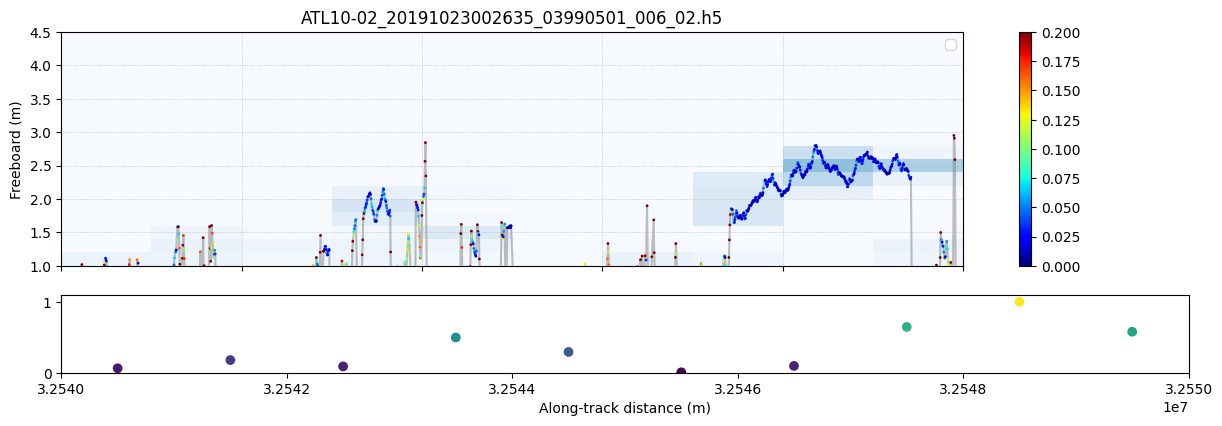

In [255]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(2,1, figsize = (12, 4), gridspec_kw={'height_ratios': [3, 1]}, sharex = True)
fig.tight_layout()

pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.5)
sc = ax[0].scatter(seg_x, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 5) # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma
fig.colorbar(sc)
ax[0].legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax[0].axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)

ax[0].set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32540*1000, 32560*1000);
ax[0].set_xlim(32540*1000, 32550*1000);
# ax[0].set_xlim(32872.5*1000, 32882.5*1000);
ax[0].set_ylim(1, 4.5);

a = np.sum(ratio[5:, ], axis = 0)
ax[1].scatter(xx[0, :], a, c = a)
ax[1].set_ylim(0.0, 1.1)
ax[1].set_xlabel("Along-track distance (m)")

plt.show()
# plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191005125113_01320501_006_02.h5


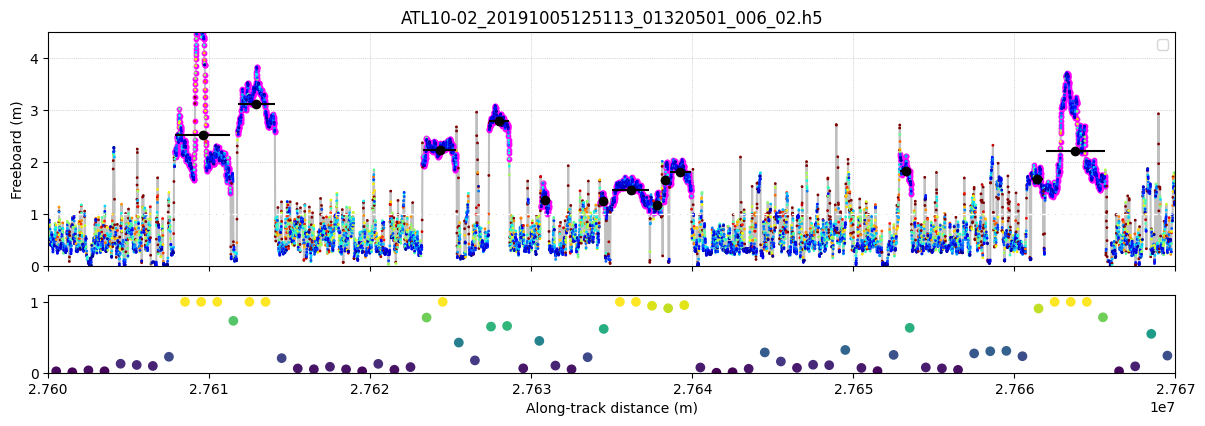

In [651]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(2,1, figsize = (12, 4), gridspec_kw={'height_ratios': [3, 1]}, sharex = True)
fig.tight_layout()

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.5)
sc = ax[0].scatter(seg_x, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax[0].scatter(seg_x[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

ax[0].errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
# fig.colorbar(sc)
ax[0].legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax[0].axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)

ax[0].set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32540*1000, 32620*1000);
# ax[0].set_xlim(32560*1000, 32580*1000);
# ax[0].set_xlim(32540*1000, 32560*1000);
# ax[0].set_xlim(32872.5*1000, 32882.5*1000);
# ax[0].set_xlim(32697.5*1000, 32705*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);

ax[0].set_xlim(27600*1000, 27670*1000);
ax[0].set_ylim(0, 4.5);

a = np.sum(ratio[5:, ], axis = 0)
ax[1].scatter(xx[0, :], a, c = a)
ax[1].set_ylim(0.0, 1.1)
ax[1].set_xlabel("Along-track distance (m)")

plt.show()
# plt.close()

In [642]:
ib_mask3

array([False, False, False, ..., False, False, False])

In [641]:
df_ib2

,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
8,-66.758148,-55.075900,2.751517e+07,66545.0,66591.0,1.774768,1.986350,1.051248,0.171473,307.849823
10,-67.599186,-55.326757,2.760959e+07,75612.0,76136.0,2.517295,4.679867,0.365546,0.924735,3449.202316
11,-67.628813,-55.335948,2.761292e+07,76194.0,76546.0,3.113596,3.825711,2.528698,0.288546,2304.830171
12,-67.730180,-55.367825,2.762431e+07,77882.0,78199.0,2.236157,2.460335,1.843640,0.129044,2079.363266
13,-67.763130,-55.377931,2.762801e+07,78482.0,78671.0,2.781950,3.084039,1.955690,0.153398,1230.300540
14,-67.788493,-55.385646,2.763085e+07,78959.0,79031.0,1.256609,1.600289,0.660537,0.157481,482.430888
15,-67.820366,-55.395375,2.763443e+07,79490.0,79535.0,1.251099,1.403426,0.189387,0.179874,297.256535
16,-67.835922,-55.400106,2.763618e+07,79597.0,79947.0,1.456297,1.714460,1.035936,0.155945,2305.428940
18,-67.850279,-55.404459,2.763779e+07,79984.0,80037.0,1.177688,1.415224,1.009412,0.125481,355.310391
19,-67.855103,-55.405939,2.763833e+07,80069.0,80113.0,1.646357,1.991160,1.235387,0.274014,291.159064


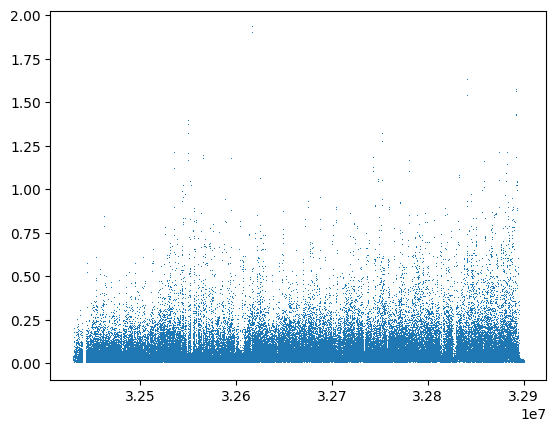

In [189]:
fb_std = pd.Series(fb).rolling(3).std().values
plt.plot(seg_x, fb_std, ',')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


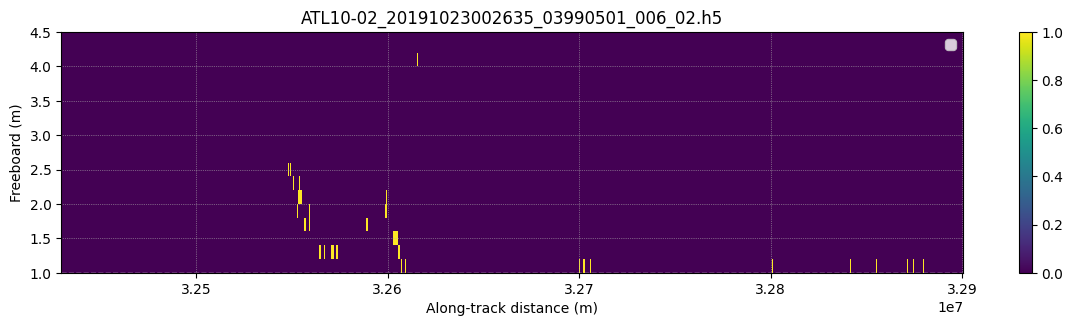

In [182]:
%matplotlib inline

filter[ratio > 0.4] = 1


print(filename)
fig, ax = plt.subplots(1,1, figsize = (12, 3))
fig.tight_layout()
pm = ax.pcolormesh(xx, yy, filter, zorder = 0)
# sc = ax.scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02, zorder = 5) # sigma
fig.colorbar(pm)
ax.legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)
ax.set_xlabel("Along-track distance (m)")
ax.set_ylabel("Freeboard (m)");

# ax.set_xlim(32614*1000, 32617*1000);
# ax.set_xlim(32540*1000, 32560*1000);
# ax.set_xlim(32840*1000, 32895*1000);
ax.set_ylim(1, 4.5);

plt.show()
# plt.close()

In [19]:
with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    strong_beams = []

    if orient == 0:
        for i in [1, 2, 3]:
            if f"gt{i}l" in f.keys():
                strong_beams.append(f"gt{i}l")
    elif orient == 1:
        for i in [1, 2, 3]:
            if f"gt{i}r" in f.keys():
                strong_beams.append(f"gt{i}r")

    for beam in strong_beams[beam_num:beam_num+1]:

        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2])

        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]

        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
        sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
        asr = f[beam]['freeboard_segment/heights/asr_25'][idx]
        bck = f[beam]['freeboard_segment/heights/background_r_norm'][idx]
        rms = f[beam]['freeboard_segment/heights/height_segment_rms'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]

        print(f[beam]['freeboard_segment/heights'].keys())

<KeysViewHDF5 ['asr_25', 'backgr_calc', 'backgr_r_200', 'backgr_r_25', 'background_r_norm', 'bsnow_con', 'bsnow_h', 'cloud_flag_asr', 'cloud_flag_atm', 'delta_time', 'height_segment_confidence', 'height_segment_dist2land', 'height_segment_height', 'height_segment_length_seg', 'height_segment_ocdepth', 'height_segment_rms', 'height_segment_sigma', 'height_segment_ssh_flag', 'height_segment_type', 'height_segment_w_gaussian', 'ice_conc_amsr2', 'ice_conc_ssmi', 'latitude', 'layer_flag', 'longitude', 'msw_flag', 'photon_rate', 'podppd_flag']>


In [155]:
X

array([ 3.61268028e-09+0.00000000e+00j,  1.25966509e+03+7.43072867e+04j,
        1.53982402e+03+3.78706580e+04j, ...,
       -3.45859673e+00-4.56488630e-02j, -3.45279132e+00-2.90427881e-02j,
       -3.45105987e+00-5.86040679e-03j])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


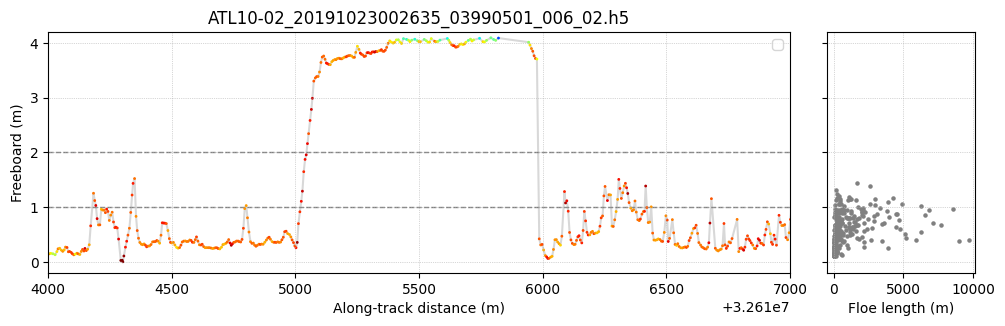

In [160]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(1,2, figsize = (10, 3), gridspec_kw={'width_ratios': [5, 1]}, sharey = True)
fig.tight_layout()
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.3)
ax[0].plot(year + spots.mean(), spots)
# ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma
ax[0].scatter(seg_x, fb, c=ph_rate, s= 1, cmap = "jet", vmax = 10) # photon rate

ax[0].legend()
ax[0].axhline(1, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)
ax[0].axhline(2, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)
ax[0].set_xlabel("Along-track distance (m)")
ax[0].set_ylabel("Freeboard (m)");

ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32598*1000, 32609*1000);
ax[0].set_ylim(-0.2, 4.2);

ax[1].scatter(floe_len0, fb_mean0, s = 5, c = "gray")
ax[1].grid(ls = ":", lw = 0.5)
ax[1].set_xlabel("Floe length (m)")
# ax[1].set_xscale('log')

plt.show()
# plt.close()

In [3]:
year = 2019
df_all = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_{year}.csv", index_col = 0)

bbox = [-62, -77.6, -15, -60]

In [19]:
df_all.head(5)

,filename,beam,beam_num,year,month,day,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
0,ATL10-02_20190106015150_01320201_006_02.h5,gt1l,0,2019,1,6,-74.601091,-58.051187,2.839684e+07,40357.0,40441.0,3.382634,3.622471,2.905646,0.162428,467.942822
1,ATL10-02_20190106015150_01320201_006_02.h5,gt1l,0,2019,1,6,-74.698437,-58.105523,2.840783e+07,41940.0,42035.0,3.659101,4.088406,0.090341,0.389613,1376.631922
2,ATL10-02_20190106015150_01320201_006_02.h5,gt2l,1,2019,1,6,-74.592710,-58.161513,2.839640e+07,32842.0,32881.0,2.973534,3.092570,2.750389,0.092182,273.630694
3,ATL10-02_20190106015150_01320201_006_02.h5,gt2l,1,2019,1,6,-74.691138,-58.217169,2.840750e+07,34142.0,34726.0,3.707140,4.193796,2.539752,0.277467,4100.056202
4,ATL10-02_20190106142608_01400201_006_02.h5,gt1l,0,2019,1,6,-76.182618,-53.830011,3.163831e+07,20.0,145.0,2.378184,3.122895,1.873965,0.362548,675.041457


In [86]:
ib_count = df_all.groupby('filename', as_index = False).count()

In [87]:
ib_count[ib_count["beam"] > 10]

,filename,beam,beam_num,year,month,day,lat,lon,seg_x,id_st,id_en,fb_mean,fb_max,fb_min,fb_std,width
11,ATL10-02_20190201234503_05430201_006_02.h5,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
12,ATL10-02_20190205233644_06040201_006_02.h5,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46
16,ATL10-02_20190219112019_08100201_006_02.h5,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
26,ATL10-02_20190302222103_09850201_006_02.h5,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
29,ATL10-02_20190310110421_11000201_006_02.h5,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,ATL10-02_20191120102817_08330501_006_01.h5,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
290,ATL10-02_20191120230236_08410501_006_01.h5,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
295,ATL10-02_20191124101957_08940501_006_01.h5,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38
302,ATL10-02_20191129094557_09700501_006_01.h5,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13


In [17]:
filename = "D:\\Floes\\ATL10\\ATL10-02_20190310110421_11000201_006_02.h5"
# filename = "D:\\Floes\\ATL10\\ATL10-02_20191023002635_03990501_006_02.h5"
beam_num = 2

bbox = [-62, -77.6, -15, -60]

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    strong_beams = []

    if orient == 0:
        for i in [1, 2, 3]:
            if f"gt{i}l" in f.keys():
                strong_beams.append(f"gt{i}l")
    elif orient == 1:
        for i in [1, 2, 3]:
            if f"gt{i}r" in f.keys():
                strong_beams.append(f"gt{i}r")

    for beam in strong_beams[beam_num:beam_num+1]:

        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2]) & (fb <= 10)

        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]

        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
        sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]
        fb_std = pd.Series(fb).rolling(3, center = True).std().values

        df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len, 'fb': fb,
                           'fb_std': fb_std, 'ph_rate': ph_rate, 'sigma': sigma})

        # ib_mask = (fb > 1.0) & (sigma < 0.03) & (fb_std < 0.1)
        ib_mask2, df_ib = determine_iceberg(df, th_fb = 0.8, th_sigma = 0.02, th_std = 0.1)
        df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2, th_fb = 0.8)

print(filename)

D:\Floes\ATL10\ATL10-02_20190310110421_11000201_006_02.h5


D:\Floes\ATL10\ATL10-02_20190310110421_11000201_006_02.h5


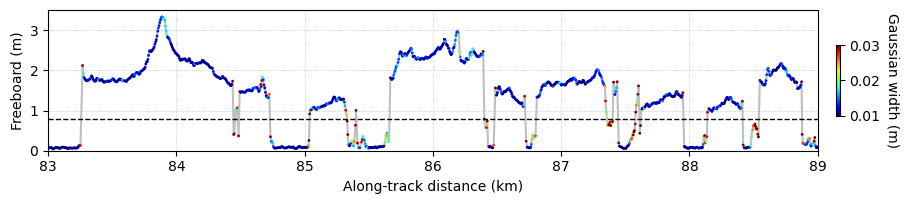

In [18]:
# %matplotlib widget
print(filename)
fig, ax = plt.subplots(1,1, figsize = (10, 2), dpi = 100, sharex = True)
fig.tight_layout()
seg_x_km = (seg_x - seg_x.min()) / 1000

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax.plot(seg_x_km, fb, c="gray", zorder=1, alpha = 0.5)
# sc = ax.scatter(seg_x_km, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
sc = ax.scatter(seg_x_km, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.03, vmin = 0.01, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
# sc = ax.scatter(seg_x_km[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax.errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
cb = fig.colorbar(sc, pad = 0.02, shrink = 0.5)
cb.set_label(f"Gaussian width (m)", rotation = 270, va = "bottom")
# ax.legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(0.8, ls = "--", lw = 1, c="k", zorder=2)

# ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)

ax.set_ylabel("Freeboard (m)");
ax.set_xlabel("Along-track distance (km)");

# ax[0].set_xlim(seg_x[int(df_ib2.loc[0, 'id_st'])]-1000, seg_x[int(df_ib2['id_st'].values[-1])]+1000);
ax.set_ylim(0, 3.5);
ax.set_xlim(83, 89);

plt.show()
# plt.close()

D:\Floes\ATL10\ATL10-02_20190310110421_11000201_006_02.h5


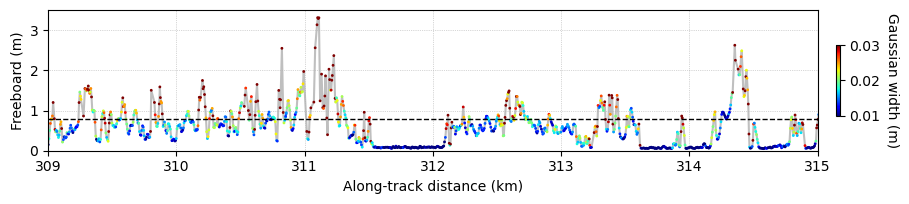

In [20]:
# %matplotlib widget
print(filename)
fig, ax = plt.subplots(1,1, figsize = (10, 2), dpi = 100, sharex = True)
fig.tight_layout()
seg_x_km = (seg_x - seg_x.min()) / 1000

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax.plot(seg_x_km, fb, c="gray", zorder=1, alpha = 0.5)
# sc = ax.scatter(seg_x_km, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
sc = ax.scatter(seg_x_km, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.03, vmin = 0.01, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
# sc = ax.scatter(seg_x_km[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax.errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
cb = fig.colorbar(sc, pad = 0.02, shrink = 0.5)
cb.set_label(f"Gaussian width (m)", rotation = 270, va = "bottom")
# ax.legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(0.8, ls = "--", lw = 1, c="k", zorder=2)

# ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)

ax.set_ylabel("Freeboard (m)");
ax.set_xlabel("Along-track distance (km)");

# ax[0].set_xlim(seg_x[int(df_ib2.loc[0, 'id_st'])]-1000, seg_x[int(df_ib2['id_st'].values[-1])]+1000);
ax.set_ylim(0, 3.5);
ax.set_xlim(309, 315);

plt.show()

D:\Floes\ATL10\ATL10-02_20190310110421_11000201_006_02.h5


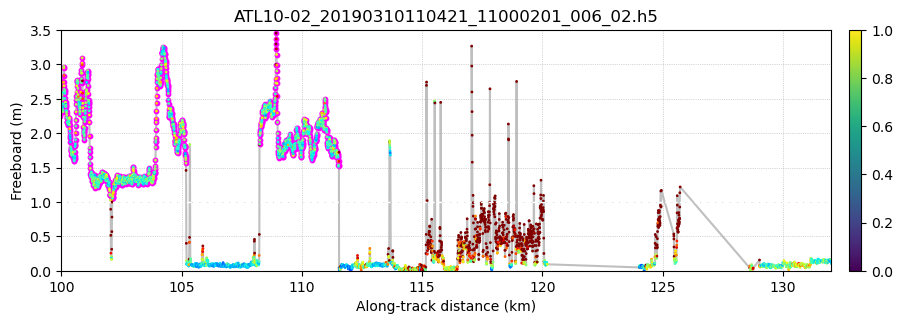

In [82]:
# %matplotlib widget
print(filename)
fig, ax = plt.subplots(1,1, figsize = (10, 3), sharex = True)
fig.tight_layout()
seg_x_km = (seg_x - seg_x.min()) / 1000

# pm = ax[0].pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax.plot(seg_x_km, fb, c="gray", zorder=1, alpha = 0.5)
# sc = ax.scatter(seg_x_km, fb, c=fb_std, s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby
sc = ax.scatter(seg_x_km, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02, zorder = 2) # std. freeboard nearby

# sc = ax[0].scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax.scatter(seg_x_km[ib_mask3], fb[ib_mask3], s= 10, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax.errorbar(df_ib2['seg_x'], df_ib2['fb_mean'], xerr = df_ib2['width']/2, fmt ='o', color = "k")
fig.colorbar(sc, pad = 0.02)
# ax.legend()
# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)

ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)

ax.set_ylabel("Freeboard (m)");
ax.set_xlabel("Along-track distance (km)");

# ax[0].set_xlim(32614*1000, 32617*1000);
# ax[0].set_xlim(32540*1000, 32620*1000);
# ax[0].set_xlim(32560*1000, 32580*1000);
# ax[0].set_xlim(32540*1000, 32560*1000);
# ax[0].set_xlim(32872.5*1000, 32882.5*1000);
# ax[0].set_xlim(32697.5*1000, 32705*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);
# ax[0].set_xlim(32660.5*1000, 32680*1000);

# ax[0].set_xlim(seg_x[int(df_ib2.loc[0, 'id_st'])]-1000, seg_x[int(df_ib2['id_st'].values[-1])]+1000);
ax.set_ylim(0, 3.5);
ax.set_xlim(100, 132);

plt.show()
# plt.close()